## Acoustic Scattering Produced by a Circular Obstacle in an Infinite Domain

In [36]:
import numpy as np
from scat_circ import sound_hard_circle_calc
from scat_circ import mask_displacement
from scat_circ import plot_displacement_amplitude
from scat_circ import plot_mesh_from_file
from scat_circ import measure_execution_time
from scat_circ import process_onelab_data
from scat_circ import plot_fem_results
from scat_circ import interpolate_fem_data
from scat_circ import calc_error
from pinns_scat_circ import generate_points
from pinns_scat_circ import plot_points
from pinns_scat_circ import initialize_and_load_model
from pinns_scat_circ import predict_u 
from pinns_scat_circ import measure_model_time_pinns

#### Parameters of the model

- $ r_i$ - Inner radius [m].
- $ r_e$ - Outer radius [m].
- $ k$ -  Wave number [a.u.].

In [37]:
r_i = np.pi/4 # Inner radius
r_e = np.pi # Outer radius
k = 3.0  # Wave number
n_grid = 501 # Number of grid points in x and y 

# Create a grid of points in the domain
Y, X = np.mgrid[-r_e:r_e:n_grid*1j, -r_e:r_e:n_grid*1j]

### Analytical Solution

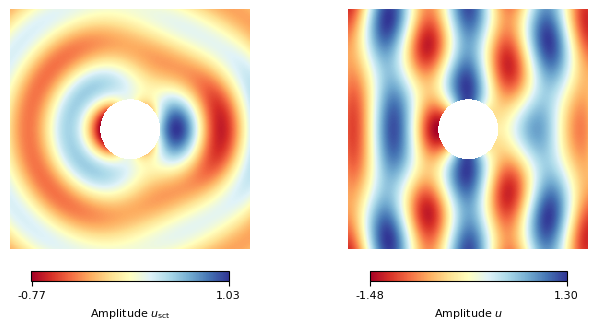

In [38]:
# Calculate the radial distance from the origin for each point in the grid
R_exact = np.sqrt(X**2 + Y**2)

# Calculate the displacement for a sound-hard circular obstacle
# n_terms: number of terms in the series expansion
u_sc, u = sound_hard_circle_calc(k, r_i, X, Y, n_terms=None)

# Mask the displacement
u_sc, u = mask_displacement(R_exact, r_i, r_e, u_sc, u)

# Plot the displacement amplitude
plot_displacement_amplitude(X, Y, np.real(u_sc), np.real(u))

### Finite Element Method (FEM)

#### Mesh

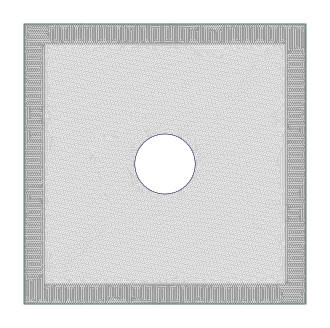

Nodes = 23472, Physical Domain Connections = 48711, Absorbing Layer Connections = 19060


In [39]:
# plot the mesh from the file
file_path_msh = "AcousticScattering/scattering.msh"
num_nodes, num_connections_P, num_connections_A = plot_mesh_from_file(file_path_msh)

# You can use the returned values for further processing
print(f"Nodes = {num_nodes}, Physical Domain Connections = {num_connections_P}, Absorbing Layer Connections = {num_connections_A}") 

#### FEM solution

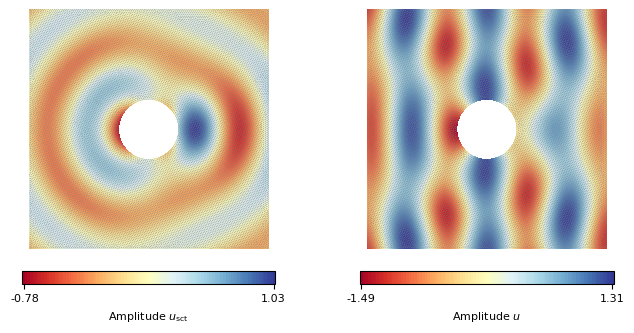

In [40]:
# data u_scn
file_path_u_scn = "AcousticScattering/u.pos"
X_fem, Y_fem, elements_fem, uscn_amp_fem = process_onelab_data(file_path_u_scn)

# data u
file_path_u = "AcousticScattering/u_Total.pos"
_, _, _, u_amp_fem = process_onelab_data(file_path_u)

# Show the FEM results
plot_fem_results(X_fem, Y_fem, elements_fem, uscn_amp_fem, u_amp_fem)

#### Accuracy

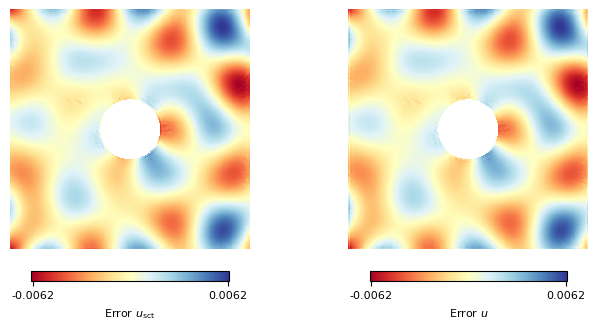

Relative error for u_scn: 7.11e-03
Relative error for u: 2.39e-03


In [41]:
# Interpolate the FEM data
X_grid, Y_grid, u_amp_interp_fem, uscn_amp_interp_fem = interpolate_fem_data(X_fem, Y_fem, u_amp_fem, uscn_amp_fem, r_i, r_e, n_grid)

# Mask the displacement
u_amp_interp_fem, uscn_amp_interp_fem = mask_displacement(R_exact, r_i, r_e, u_amp_interp_fem, uscn_amp_interp_fem)

# Plot difference and calculate relative error
rel_error_uscn, rel_error_u = calc_error(X, Y, np.real(u_sc), np.real(u), uscn_amp_interp_fem, u_amp_interp_fem, r_i, r_e)    

# Print the relative error in scientific notation
print(f"Relative error for u_scn: {rel_error_uscn:.2e}")
print(f"Relative error for u: {rel_error_u:.2e}")

#### Computation time

In [42]:
# Define the path to the getdp executable (this can be changed per machine)
getdp_path = "/home/orincon/onelab-Linux64/getdp"

# Define the rest of the command arguments to solve the model using getdp
command_args = "AcousticScattering/scattering.pro -solve Scattering -pos Wave -v2"

# Number of runs to measure statistically
num_runs = 10  # You can change this based on how many runs you want

# Example usage
average_time, std_dev_time, min_time, max_time = measure_execution_time(getdp_path, command_args, num_runs)
print(f"Statistical Measurement of Execution Time (over {num_runs} runs):")
print(f"Average Time: {average_time:.2f} seconds")
print(f"Standard Deviation: {std_dev_time:.2f} seconds")
print(f"Minimum Time: {min_time:.2f} seconds")
print(f"Maximum Time: {max_time:.2f} seconds")

Statistical Measurement of Execution Time (over 10 runs):
Average Time: 1.18 seconds
Standard Deviation: 0.03 seconds
Minimum Time: 1.13 seconds
Maximum Time: 1.23 seconds


### Physics informed neural networks (PINNs)

#### Collocation points

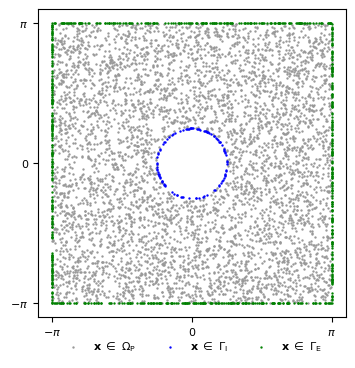

In [43]:
# Parameters
n_Omega_P = 5_000        # Number of points inside the annular region
n_Gamma_I = 100          # Number of points on the inner boundary (r = r_i)
n_Gamma_E = 200          # Number of points on the outer boundary (r = r_e)
r_i = np.pi / 4          # Inner radius
r_e = np.pi              # Outer radius
k = 3.0                  # Wave number
iter = 0                 # Iteration counter
side_length = 2 * r_e    # Side length of the square

# Generate points
x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top = generate_points(n_Omega_P, side_length, r_i, n_Gamma_I, n_Gamma_E)
plot_points(x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top)

#### Physics informed neural networks (PINNs) solution

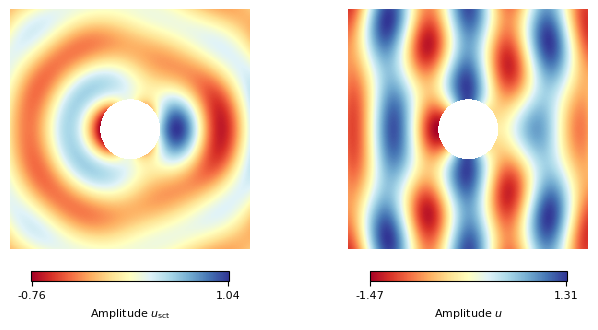

In [44]:
# Initialize and load the model
model_path = 'Scattering.pt'
model = initialize_and_load_model(model_path)

# Predict the displacement
u_sc_pred, u_pred = predict_u(model, r_e, r_i, k, n_grid)

# Plot the displacement amplitude
plot_displacement_amplitude(X, Y, u_sc_pred, u_pred)

#### Accuracy

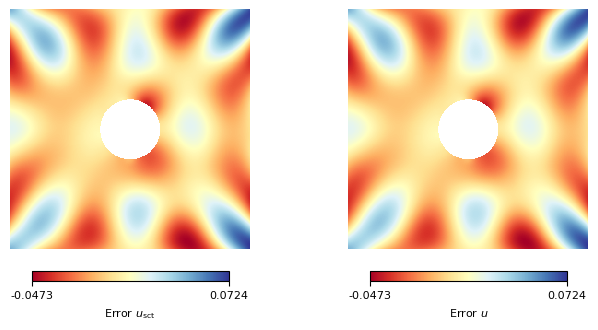

Relative error for u_scn: 7.47e-02
Relative error for u: 2.51e-02


In [45]:
# Plot difference and calculate relative error
rel_error_uscn, rel_error_u = calc_error(X, Y, np.real(u_sc), np.real(u), u_sc_pred, u_pred, r_i, r_e)    

# Print the relative error in scientific notation
print(f"Relative error for u_scn: {rel_error_uscn:.2e}")
print(f"Relative error for u: {rel_error_u:.2e}")

#### Computation time

In [47]:
num_runs = 10
timing_results = measure_model_time_pinns(model, r_e, r_i, k, n_grid, num_runs)
print(f"Average time: {timing_results['average_time']} seconds")
print(f"Standard deviation: {timing_results['std_dev_time']} seconds")
print(f"Minimum time: {timing_results['min_time']} seconds")
print(f"Maximum time: {timing_results['max_time']} seconds")

Average time: 0.08746769479985232 seconds
Standard deviation: 0.04379700725983488 seconds
Minimum time: 0.06434531199920457 seconds
Maximum time: 0.21730872999614803 seconds
